# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? test  and discuss the results in this cell**

In [4]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images

In [5]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [7]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed, by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images shows input data, while the second one shows the reconstructions.

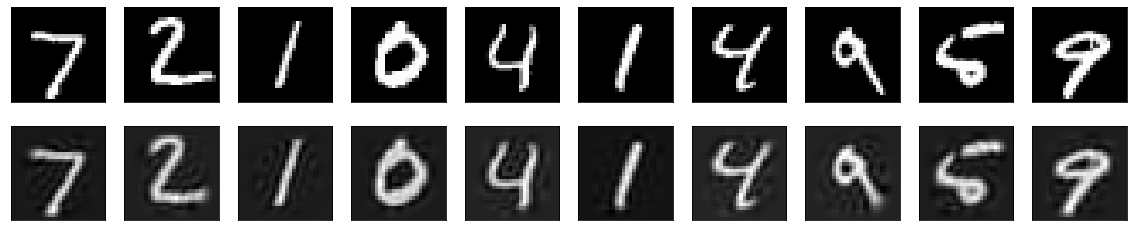

In [8]:
plot_img(10, x_test, x_test_reco)

## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**


In [9]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [11]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0846 - val_loss: 0.0142
Epoch 2/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0124 - val_loss: 0.0094
Epoch 3/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/

Plot the loss and the accuracy curves, and the accuracy on the test set.

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0047
test mse: 0.00475


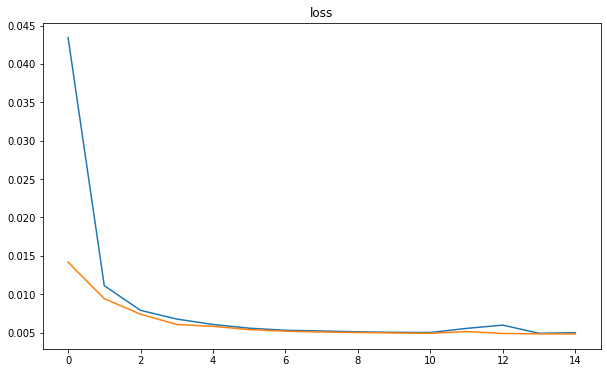

In [13]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

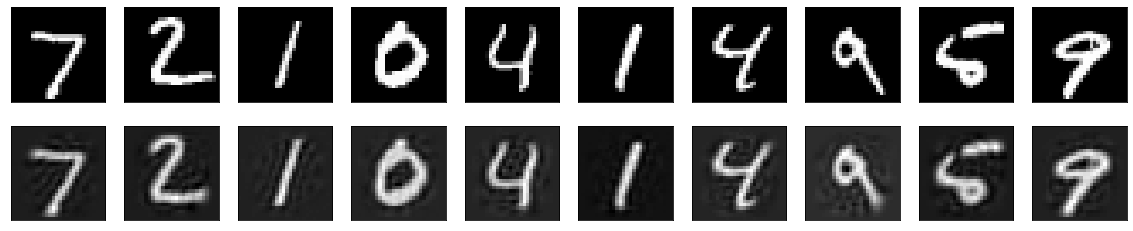

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


There isn't really much to conclude besides the fact that the SVD performs a slightly better. Training the shallow model takes more time compared to the linear SVD. In principal, since SVD is a linear transformation of the data, it reduces the dimensionality to a linear subspace, as we are doing with the autoencoder using a linear activation. Such a linear encoder and the representation learnt by PCA are equivalent. Also, the representation learnt with SVD can be computed in a deterministic way, unlike the case of neural networks. In fact, if Stochastic Gradient Descent method was used the results would have been slightly different.



#### THEORETICAL PART 

* Singular Values Decomposition is an algebraic solution to factorize a matrix into singular vectors and singular values. It transforms a general matrix A in a multiplication of 2 square orthogonal matrix U & V and a diagonal matrix D which is not necessarily square.

* An autoencoder is a neural network trained with the attempt to reduce the dimension of the input by constructing a model that is forced to prioritize which aspects of the input should be copied and which are the properties of the data.

* The attempt to reduce the dimension of the data can be done in an algebraic form with the SVD method, if we consider the input a matrix mxn where m is the number of samples and n the number of features.

## Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**


In [15]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


In [16]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0750 - val_loss: 0.0352
Epoch 2/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0315 - val_loss: 0.0226
Epoch 3/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0209 - val_loss: 0.0165
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 5/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 6/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 7/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 8/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 9/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 11/

313/313 - 0s - loss: 0.0042
test mse: 0.00421


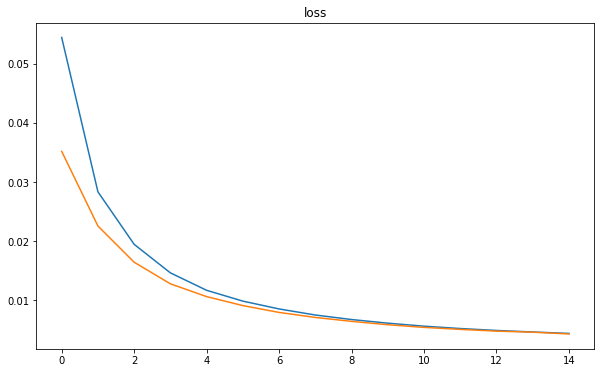

In [18]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

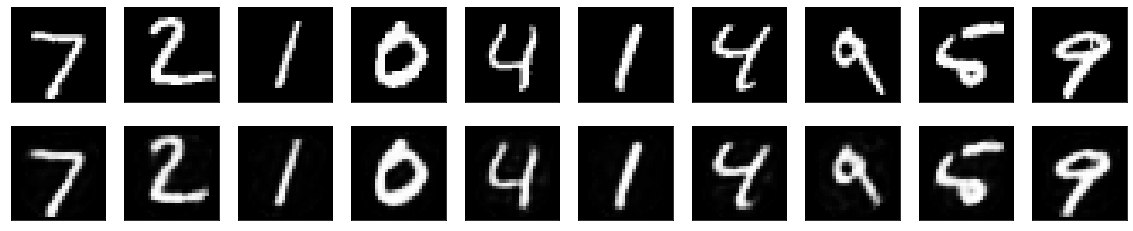

In [19]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


In the non-linear case, the encoder happens to be a nonlinear curve (i.e. the manifold) unlike the linear encoder defined by the linear model (xTw). I've replaced both linear activation functions with a sigmoid. This network structure can be thought of SVD with non-linear transformation. Sigmoid did the best job, reducing the error to 0.00421. Whereas, softmax and ReLU did the worst job producing the highest overfit of the model. When compared to the linear autoendocer, using a sigmoid activation function increases the performance but not significantly. It can be concluded that the encoder and decoder being linear does not reflect a limitation of the autoencoder but simply our modeling choice.

## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [23]:
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))

#To_complete


#Define the encoder...
encoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)

encoded2 = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(encoded1)

#...and the decoder...
decoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded2)
decoded2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded1)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded2)

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [24]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0830 - val_loss: 0.0612
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0581 - val_loss: 0.0454
Epoch 3/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0421 - val_loss: 0.0343
Epoch 4/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0325 - val_loss: 0.0275
Epoch 5/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0269 - val_loss: 0.0242
Epoch 6/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0234 - val_loss: 0.0209
Epoch 7/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 8/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0186 - val_loss: 0.0173
Epoch 9/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0173 - val_loss: 0.0160
Epoch 10/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 11/

313/313 - 0s - loss: 0.0113
test mse: 0.01133


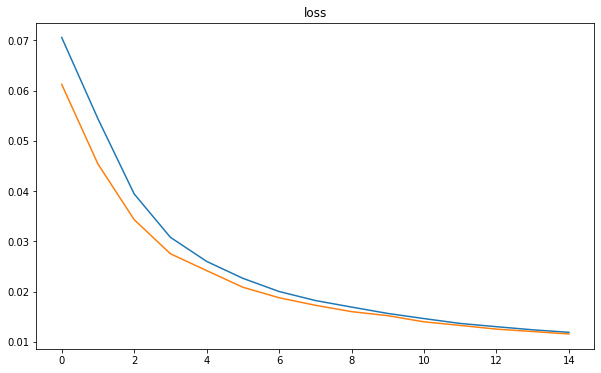

In [26]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

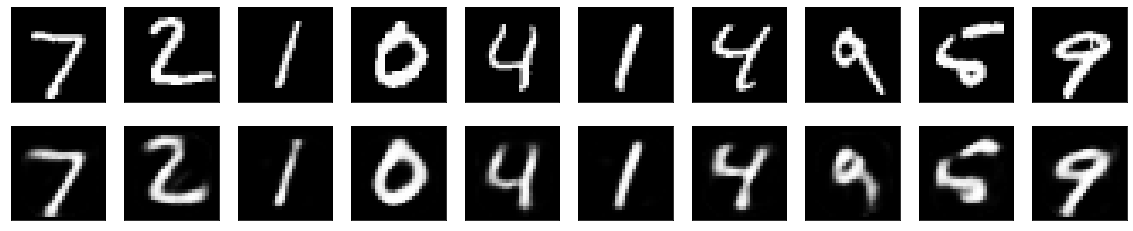

In [27]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

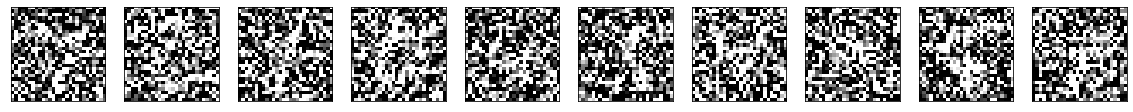

In [29]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**To_complete: use the same model defined in the exercise 5.3.**

In [30]:
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)
encoded2 = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(encoded1)

#...and the decoder...
decoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded2)
decoded2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded1)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded2)

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [31]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


**To complete: Train the model by passing the noisy input and the clean target.**

In [32]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0832 - val_loss: 0.0675
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0670 - val_loss: 0.0627
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0626 - val_loss: 0.0615
Epoch 4/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0611 - val_loss: 0.0587
Epoch 5/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0583 - val_loss: 0.0564
Epoch 6/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0564 - val_loss: 0.0554
Epoch 7/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0548 - val_loss: 0.0542
Epoch 8/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0535 - val_loss: 0.0532
Epoch 9/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0519 - val_loss: 0.0499
Epoch 10/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0491 - val_loss: 0.0482
Epoch 11/

313/313 - 0s - loss: 0.0453
test mse: 0.04533


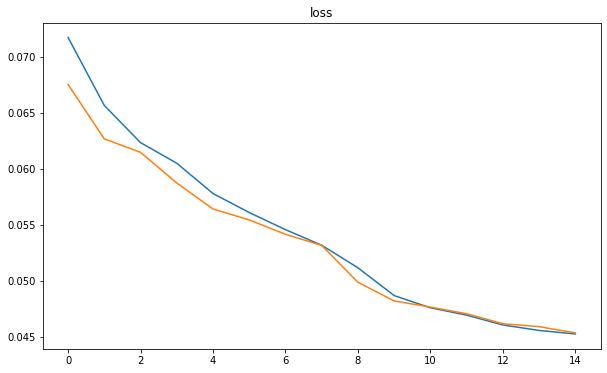

In [33]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the correspondent denoised outputs

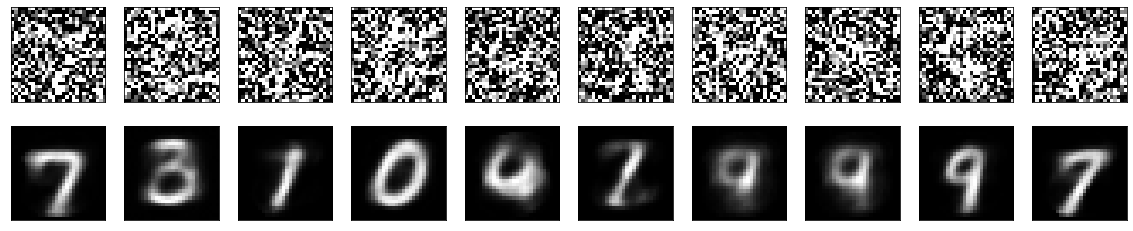

In [34]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [35]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


   8192/1641221 [..............................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


1646592/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [36]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [37]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 74ms/step - loss: 0.4891 - categorical_accuracy: 0.0579 - val_loss: 0.1041 - val_categorical_accuracy: 0.3588
Epoch 2/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0914 - categorical_accuracy: 0.4093 - val_loss: 0.0741 - val_categorical_accuracy: 0.4621
Epoch 3/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0709 - categorical_accuracy: 0.4752 - val_loss: 0.0682 - val_categorical_accuracy: 0.4727
Epoch 4/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0655 - categorical_accuracy: 0.4964 - val_loss: 0.0622 - val_categorical_accuracy: 0.5143
Epoch 5/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0597 - categorical_accuracy: 0.5315 - val_loss: 0.0574 - val_categorical_accuracy: 0.5347
Epoch 6/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0546 - categorical_accuracy: 0.5576 - val_loss: 0.0540 - val_categorical_accuracy: 0.5474
Epoch 7/50

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

40/40 - 0s - loss: 0.0213 - categorical_accuracy: 0.8741
categorical_accuracy: 87.41%


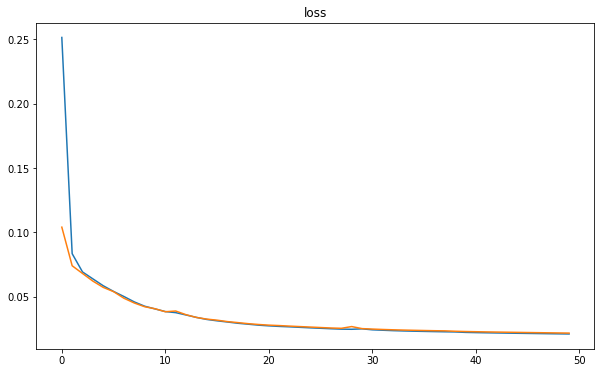

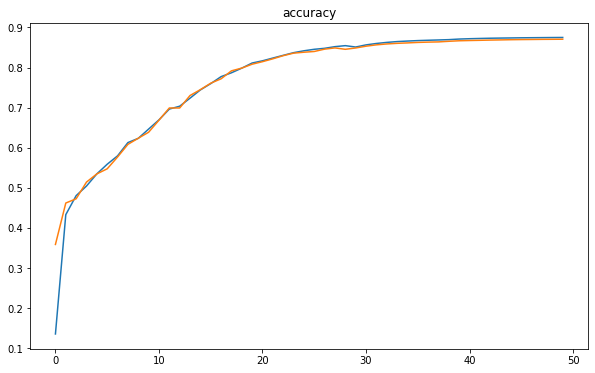

In [39]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [40]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in an of that when but that <oov> the <oov> is <oov> a <oov> <oov> film in just about <oov> <oov> <oov> <oov> only some other <oov> in <oov> <oov> it <oov> of <oov> <oov> of the film are <oov> <oov> was <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really great film that <oov> <oov> <oov> than one <oov> of <oov> <oov> i <oov> it <oov> in of <oov> and i <oov> <oov> the <oov>


## Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**


In [41]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 12s 128ms/step - loss: 0.0492 - categorical_accuracy: 0.3808 - val_loss: 0.0371 - val_categorical_accuracy: 0.4667
Epoch 2/50
79/79 [==============================] - 10s 126ms/step - loss: 0.0361 - categorical_accuracy: 0.4769 - val_loss: 0.0342 - val_categorical_accuracy: 0.4921
Epoch 3/50
79/79 [==============================] - 10s 128ms/step - loss: 0.0328 - categorical_accuracy: 0.4988 - val_loss: 0.0304 - val_categorical_accuracy: 0.4915
Epoch 4/50
79/79 [==============================] - 10s 123ms/step - loss: 0.0291 - categorical_accuracy: 0.5000 - val_loss: 0.0267 - val_categorical_accuracy: 0.4933
Epoch 5/50
79/79 [==============================] - 10s 125ms/step - loss: 0.0254 - categorical_accuracy: 0.5137 - val_loss: 0.0230 - val_categorical_accuracy: 0.5989
Epoch 6/50
79/79 [==============================] - 10s 124ms/step - loss: 0.0217 - categorical_accuracy: 0.6376 - val_loss: 0.0191 - val_categorical_accuracy: 0.731

40/40 - 1s - loss: 2.5955e-05 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


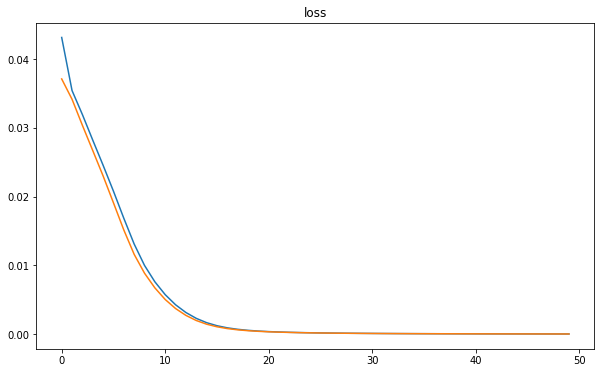

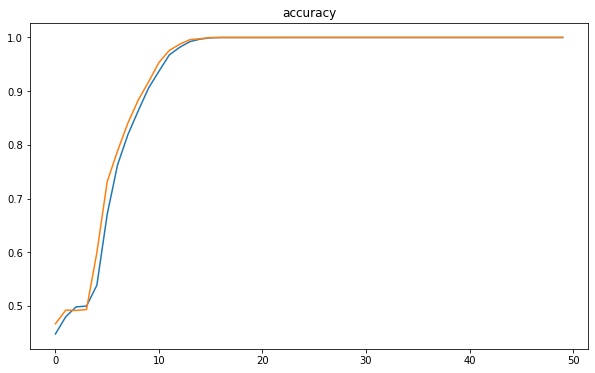

In [43]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [44]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


After testing different activation functions, it was evident that the ReLU generated a model that did not learn from the data which occured due to the vanishing gradient problem. Something similar happened when using the sigmoidal function, where the accuracy did not increase at all. Last, but not least, I tried the tahn activation which overcame these problems. With this function, the model learnt at a faster rate and required less epochs. The reason for this is that by using tahn, the second derivative was different from zero. But, since we have to manage a one-hot representation, using softmax function in the output layer yielded better results.